# Diseño de etapa supervisión de calidad de adhesivo basado en técnicas de machine learning aplicadas a la perfilometría

Este documento contendrá todo el desarrollo del bloque de _Machine Learning_ del trabajo de fin de grado _Mejora en el proceso de montaje de luminarias mediante automatización con brazo robótico y optimización de la dosificación de adhesivo_.

Autor: Alfredo Rodríguez Magdalena

Normagrup Technology (c) Copyright

In [1]:
## Librerías necesarias para el correcto funcionamiento del programa

# Librerías para el manejo de datos
import pandas as pd

# Librerías para computación científica
import numpy as np 
import scipy as sp

# Librería para entrenar el modelo
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.math import sigmoid

# Librerías para preprocesamiento de datos
from sklearn.model_selection import train_test_split

# Gráficos y visualización
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

El objetivo de esta _Jupyter Notebook_ es diseñar un algoritmo que sea capaz de clasificar los hilos de adhesivo en función de su calidad partiendo de una extracción de características superficial capaz de extraer posiciones y secciones de distintos perfiles de adhesivo.

<center><img src="./FigurasJupyter/esquemaAnexoV.png" width="1000px"></center>

## Fase 0. Obtención de datos para entrenamiento

Según lo comentado en el informe, el procedimiento a seguir para crear una inteligencia artificial con técnicas de _machine learning_ comienza con una etapa de extracción de características. Si se revisa el anexo IV, se verá el procedimiento empleado para extraer valores descriptivos de cada perfil medido por el sensor, los cuales son:
+ Sección de adhesivo $(x_1)$ $[mm^2]$
+ Posición del hilo de adhesivo con respecto al inicio de la pista $(x_2)$ $[mm]$

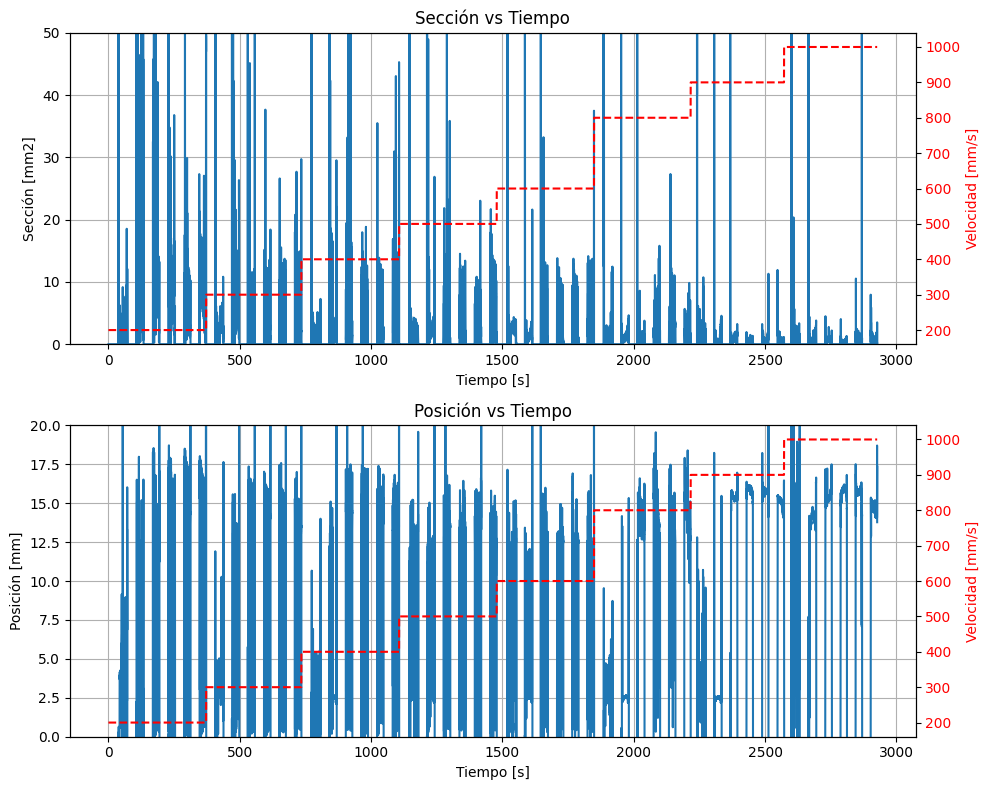

In [2]:
# Archivos de datos
dataFiles = [
            r"excar20240314121631_200",
            r"excar20240314120843_300",
            r"excar20240314115707_400",
            r"excar20240314114932_500",
            r"excar20240314114121_600",
            r"excar20240314113354_800",
            r"excar20240314112537_900",
            r"excar20240314111549_1000"
            ]

# Creación de matriz de datos
secciones = np.array([])
posiciones = np.array([])
velocidades = np.array([])

# Lectura de archivos
for file in dataFiles:
    data = pd.read_csv(r"Muestras/EntrenamientoML/"+file+r".csv")
    secciones = np.append(secciones, data["Seccion"])
    posiciones = np.append(posiciones, data["Posicion"])
    velocidades = np.append(velocidades, data["Velocidad"])

# Tiempo de recogida de datos por bandeja
tBandeja = 365.84 # segundos

# Tiempo total de recogida de datos
T = tBandeja * len(dataFiles)

# Número de datos
Q = len(secciones)

# Vector de tiempos para mostrar los datos
t = np.arange(0, Q, 1) * (T/Q)

# Creación de figura con dos subplots alineados verticalmente
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Sección vs tiempo
ax1.plot(t, secciones)
ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('Sección [mm2]')
ax1.set_title('Sección vs Tiempo')
ax1.set_ylim(0,50)
ax1.grid(True)

# Velocidad en eje izquierdo de Sección vs tiempo
ax1_v = ax1.twinx()
ax1_v.plot(t, velocidades, '--r')
ax1_v.set_ylabel('Velocidad [mm/s]', color='r')
ax1_v.tick_params(axis='y', labelcolor='r')

# Posición vs tiempo
ax2.plot(t, posiciones)
ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('Posición [mm]')
ax2.set_title('Posición vs Tiempo')
ax2.set_ylim(0,20)
ax2.grid(True)

# Velocidad en eje izquierdo de Posición vs tiempo
ax2_v = ax2.twinx()
ax2_v.plot(t, velocidades, '--r')
ax2_v.set_ylabel('Velocidad [mm/s]', color='r')
ax2_v.tick_params(axis='y', labelcolor='r')

# Ajuste de los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


## Fase 1. Diseño de etapa de extracción de características del hilo de adhesivo

Una vez se han extraído los datos pertinentes de cada uno de los perfiles, es preciso analizarlos en conjunto para explorar posibles patrones de comportamiento, y ayudar al algoritmo de aprendizaje automático en su entrenamiento.

Para ello, los datos se van a analizar en ventanas de trabajo empleando el método de enventanado, pues es necesario segmentarlos para poder hacer la tarea que se está comentando.

<center><img src="./FigurasJupyter/metodoEnventanado.png" width="1200px"/></center>

Dentro de cada una de estas ventanas se deducirán los siguientes descriptores:

+ Sección media $(x_1)$
$$x_1 = \frac{1}{N}\sum^N_{j=1}{v_{j,1}}$$
+ Valor eficaz de la sección en la banda de frecuencia de 0.5 a 8.5 Hz $(x_2)$
$$x_2 = \sqrt{\frac{1}{N}\sum^N_{j=1}{V_{j,1}^2}}$$
+ Posición media de hilo en pista $(x_3)$
$$x_3 = \frac{1}{N}\sum^N_{j=1}{v_{j,2}}$$
+ Valor eficaz de posición en pista en la banda de frecuencia de 0.5 a 8.5 Hz $(x_4)$
$$x_4 = \sqrt{\frac{1}{N}\sum^N_{j=1}{V_{j,2}^2}}$$
+ Volumen dispensado de material
$$x_5 = V \approx \frac{v_{robot}}{2} \cdot t_m \cdot \left[v_{1}^{(1)}+2\sum^{N-1}_{j=1}{v_{1}^{(j)}}+v_{1}^{(N)}\right]$$
+ Caudal de deposición
$$x_6 = Q \approx \frac{V}{t_m \cdot \delta}$$

Cabe mencionar que $v$ es la matriz de características extraída de los perfiles, con N entradas y en dominio temporal. Mientras que V es esa misma matriz pero en dominio frecuencial.

In [4]:
def extraeCaracteristicasHilo(secciones : np.array, posiciones : np.array, velocidades : np.array,
                               N : int, delta : int, T : float, Q : int) -> np.array:
    """
    Función que extrae las características de una muestra de hilo
    
    Inputs:
        - secciones (np.array) : Vector con las secciones de la muestra
        - posiciones (np.array) : Vector con las posiciones de la muestra
        - N (int) : Tamaño de la ventana
        - delta (int) : Solapamiento entre ventanas
        - T (float) : Tiempo total de recogida de datos
        - Q (int) : Número de datos

    Outputs:
        - F (np.array) : Matriz de características de la muestra
    """
    # Parámetros constructivos de las ventanas
    tm = T/Q # Tiempo de muestreo
    fm = 1/tm # Frecuencia de muestreo
    f = np.arange(0, N, 1) * (fm/N) # Vector de frecuencias

    # Inicialización de matriz de características
    F = np.zeros(6)
    vRobot = np.array([])

    # Método de enventanado
    for k in range(0, Q-N, delta):
        # Obtención de arreglo con índices de la ventana
        idx = np.arange(k, k+N, 1)
        # Inicialización de vector de características
        carVector = np.zeros(6) # 6 características

        ## Secciones ##
        v1 = secciones[idx]
        # Cálculo de la media
        carVector[0] = np.mean(v1)
        # Cálculo de valor RMS en banda de frecuencia deseada
        V1 = np.abs(np.fft.fft(v1))
        armonicosSeleccionados = V1[(f >= 0.5) & (f <= 8)]
        carVector[1] = np.sqrt(np.sum(2*armonicosSeleccionados**2)/N)

        ## Posiciones ##
        v2 = posiciones[idx]
        # Cálculo de la media
        carVector[2] = np.mean(v2)
        # Cálculo de valor RMS en banda de frecuencia deseada
        V2 = np.abs(np.fft.fft(v2))
        armonicosSeleccionados = V2[(f >= 0.5) & (f <= 8)]
        carVector[3] = np.sqrt(np.sum(2*armonicosSeleccionados**2)/N)

        ## Volúmenes ##
        # Cálculo de volumen depositado
        v3 = velocidades[idx]
        vrobot = np.median(v3)
        carVector[4] = vrobot*tm/2*(v1[0]+2*np.sum(v1[1:-1])+v1[-1])
        # Cálculo de caudal de deposición
        carVector[5] = carVector[4]/(tm*delta) # OJO!! El tiempo de la ventana no es el tiempo de muestreo
        
        vRobot = np.append(vRobot, vrobot)

        # Añadir vector de características a la matriz
        F = np.vstack((F, carVector))

    # Eliminar primera fila de la matriz de características
    F = F[1:,:]

    return F, vRobot

In [5]:
# Parámetros constructivos de las ventanas
N = 50 # Tamaño de la ventana
delta = 10 # Solapamiento entre ventanas

F, vRobot = extraeCaracteristicasHilo(secciones, posiciones, velocidades, N, delta, T, Q)

print(f"Numero de muestras para enternamiento : {np.size(F,0)} vectores de R{np.size(F,1)}")

Numero de muestras para enternamiento : 4907 vectores de R6


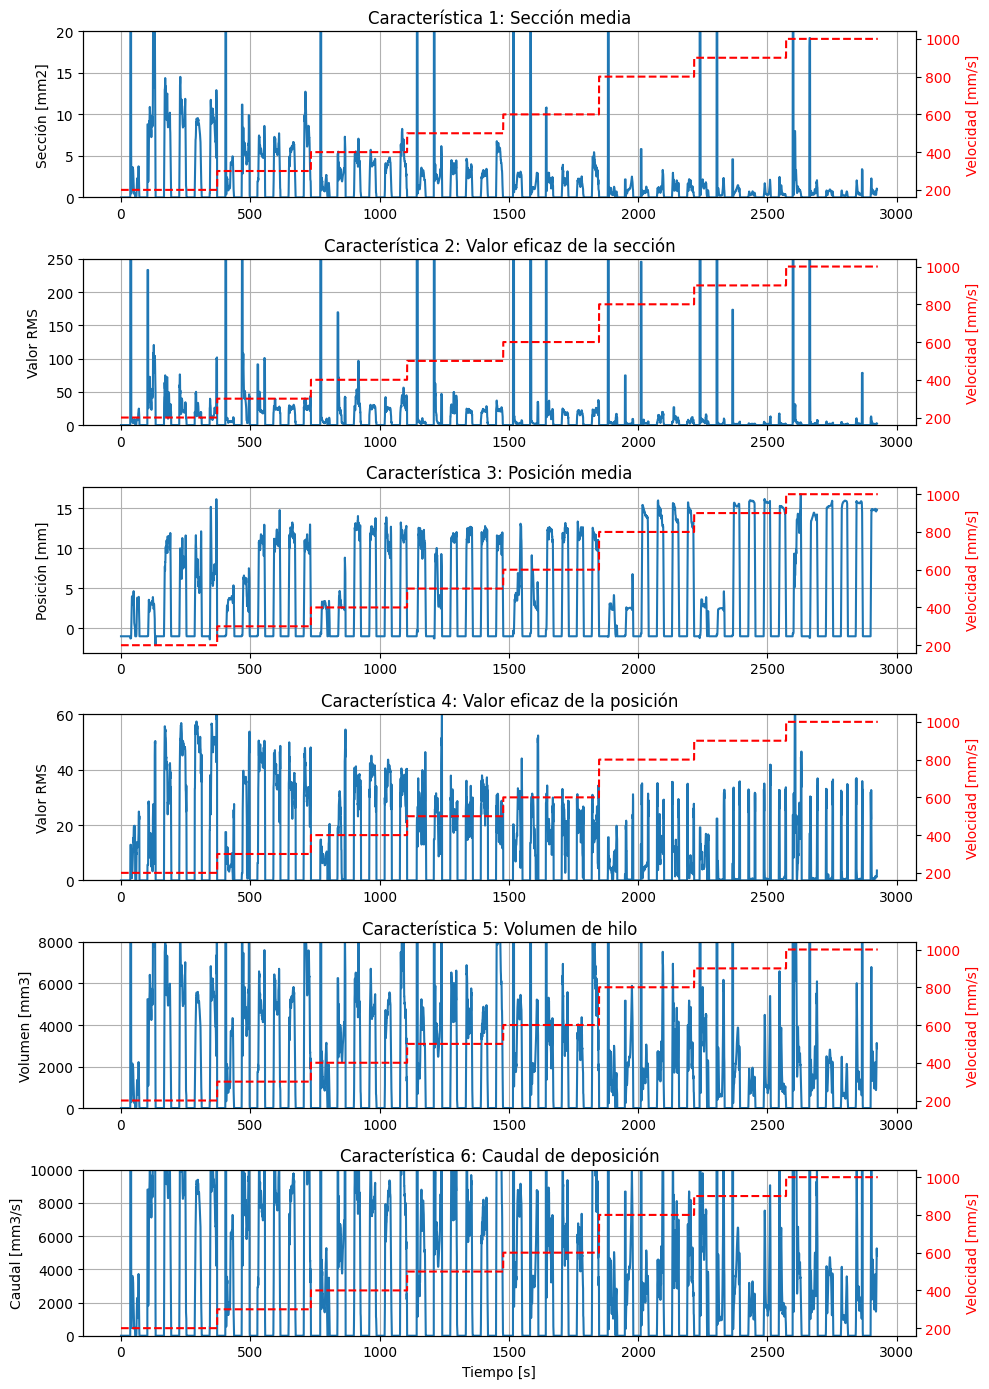

In [6]:
### Visualización de características en función del tiempo ###
# Creación de vectores de tiempo para las ventanas
tmw = (T/Q)*delta # Tiempo de muestreo para las ventanas
tw = np.arange(0, np.size(F, 0), 1) * tmw # Vector de tiempos para las ventanas

# Creación de figura con 4 subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 14))

# Mostrar en cada subplot una característica frente al tiempo
labelsEjeY = ['Sección [mm2]',
              'Valor RMS',
              'Posición [mm]',
              'Valor RMS',
              'Volumen [mm3]',
              'Caudal [mm3/s]'
              ]

titulos = ['Característica 1: Sección media',
           'Característica 2: Valor eficaz de la sección',
           'Característica 3: Posición media',
           'Característica 4: Valor eficaz de la posición',
           'Característica 5: Volumen de hilo',
           'Característica 6: Caudal de deposición'
           ]

for k in range(0, 6):
    ax1 = axs[k].twinx()  # Se crea un eje secundario para la velocidad
    axs[k].plot(tw, F[:, k])
    axs[k].set_ylabel(labelsEjeY[k])
    axs[k].set_title(titulos[k])
    axs[k].grid(True)
    ax1.plot(t, velocidades, '--r')
    ax1.set_ylabel('Velocidad [mm/s]', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    match k:
        case 0:
            axs[k].set_ylim(0, 20)
        case 1:
            axs[k].set_ylim(0, 250)
        case 3:
            axs[k].set_ylim(0, 60)
        case 4:
            axs[k].set_ylim(0, 8e3)
        case 5:
            axs[k].set_ylim(0, 1e4)

axs[-1].set_xlabel('Tiempo [s]')

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


# Guardar la figura en formato EPS
fig.savefig('resultados.eps', format='eps')

Text(0.5, 0.98, 'Espacio de características')

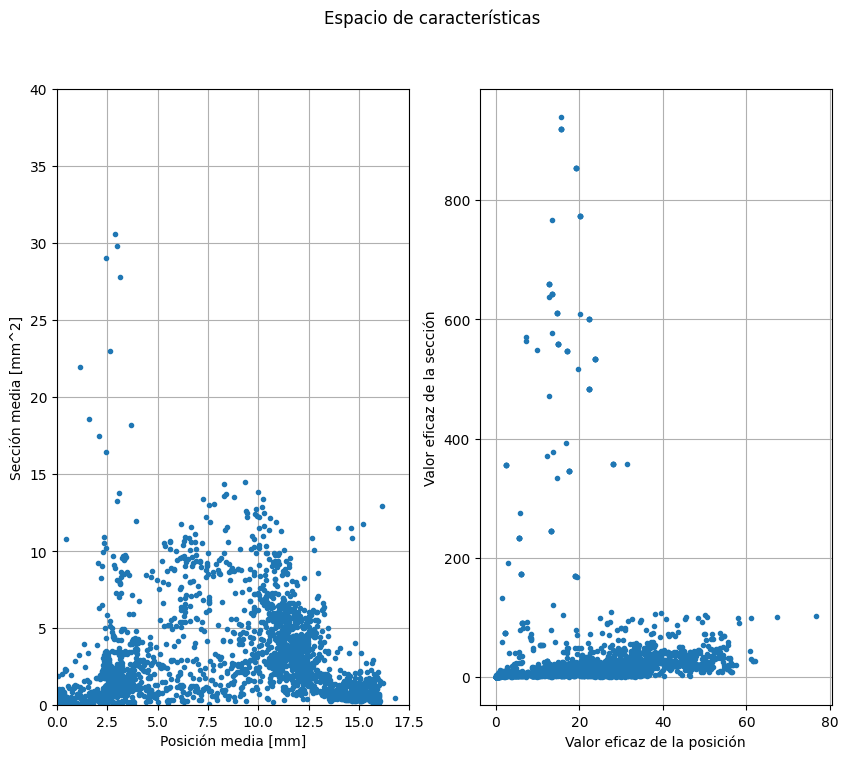

In [7]:
### Visualización del espacio de características ###
# Creación de figura con 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Posición media vs Sección media
axs[0].plot(F[:, 2], F[:, 0], '.')
axs[0].set_ylabel('Sección media [mm^2]')
axs[0].set_xlabel('Posición media [mm]')
axs[0].set_xlim(0, 17.5)
axs[0].set_ylim(0, 40)
axs[0].grid(True)

# RMS de posición vs RMS de sección
axs[1].plot(F[:, 3], F[:, 1], '.')
axs[1].set_ylabel('Valor eficaz de la sección')
axs[1].set_xlabel('Valor eficaz de la posición')
axs[1].grid(True)

fig.suptitle('Espacio de características')